# Import Library

In [90]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Load Data

In [91]:
df = pd.read_excel("Data_Historis_2015_2025.xlsx", parse_dates=['Tanggal']) #parse = untuk ngubah kolom Tanggal jadi datetime
df = df.sort_values('Tanggal')

if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

df = df.reset_index(drop=True)

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4020 entries, 0 to 4019
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Tanggal                             4020 non-null   datetime64[ns]
 1   Temperatur Minimum                  4020 non-null   object        
 2   Temperatur Maksimum                 4020 non-null   object        
 3   Temperatur Rata-rata                4020 non-null   object        
 4   Kelembapan Rata-rata                4020 non-null   object        
 5   Curah Hujan (mm)                    4020 non-null   object        
 6   Lamanya Penyinaran Matahari         4020 non-null   object        
 7   Kecepatan Angin Maksimum            4020 non-null   int64         
 8   Arah Angin Saat Kecepatan Maksimum  4020 non-null   int64         
 9   Kecepatan Angin Rata-rata           4020 non-null   int64         
 10  Arah Angin Terbanyak (°)

# Data Preparation

In [93]:
checkstripvalue = (df['Curah Hujan (mm)'] == "-").sum()
print(checkstripvalue)

497


In [94]:
df['Curah Hujan (mm)'] = df['Curah Hujan (mm)'].replace('-',0)

df['Curah Hujan (mm)'] = df['Curah Hujan (mm)'].astype(float)

C:\Users\Lenovo E15\AppData\Local\Temp\ipykernel_18428\2154469297.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Curah Hujan (mm)'] = df['Curah Hujan (mm)'].replace('-',0)


In [95]:
checkstripvalue2 = (df['Curah Hujan (mm)'] == 8888).sum()
print(checkstripvalue2)

209


In [96]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

df2 = pd.read_excel(
    "Data_Historis_2015_2025.xlsx",
    parse_dates=["Tanggal"]
)
df2 = df2.sort_values("Tanggal").reset_index(drop=True)

invalid_values = ["-", " - ", "–", "—", "N/A", "n/a", "", " ", "8888", 8888]
df2 = df2.replace(invalid_values, np.nan)

df2 = df2.replace(r'^\s*$', np.nan, regex=True)

col = "Arah Angin Terbanyak (°)"

df2[col] = (
    df2[col].astype(str)
            .str.strip()
            .str.upper()
            .str.replace("–", "-", regex=False)
            .str.replace("—", "-", regex=False)
)

mapping = {
    "C": 0, "N": 0, "NE": 45, "E": 90, "SE": 135,
    "S": 180, "SW": 225, "W": 270, "NW": 315
}

df2[col] = df2[col].map(mapping)


C:\Users\Lenovo E15\AppData\Local\Temp\ipykernel_18428\2580252007.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2 = df2.replace(invalid_values, np.nan)


# Fill Missing Values using RF Imputer for 8888 Values

In [97]:
for c in df2.columns:
    if c != "Tanggal":
        df2[c] = pd.to_numeric(df2[c], errors="coerce")

target = "Curah Hujan (mm)"

feature_cols = [
    c for c in df2.columns
    if c not in ["Tanggal", target]
]
df2[feature_cols] = df2[feature_cols].fillna(
    df2[feature_cols].median()
)


train_df = df2[df2[target].notna()]
pred_df  = df2[df2[target].isna()]

X_train = train_df[feature_cols]
y_train = train_df[target]

X_pred = pred_df[feature_cols]

rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

df2.loc[df2[target].isna(), target] = rf.predict(X_pred)

df2.to_excel("Ready_To_Use.xlsx", index=False)

In [98]:
data1= pd.read_excel('Ready_To_Use.xlsx',index_col=0)

In [99]:
data1.isna().sum().sort_values(ascending=False)


Tanggal                               0
Temperatur Minimum                    0
Temperatur Maksimum                   0
Temperatur Rata-rata                  0
Kelembapan Rata-rata                  0
Curah Hujan (mm)                      0
Lamanya Penyinaran Matahari           0
Kecepatan Angin Maksimum              0
Arah Angin Saat Kecepatan Maksimum    0
Kecepatan Angin Rata-rata             0
Arah Angin Terbanyak (°)              0
dtype: int64

# Data Understanding

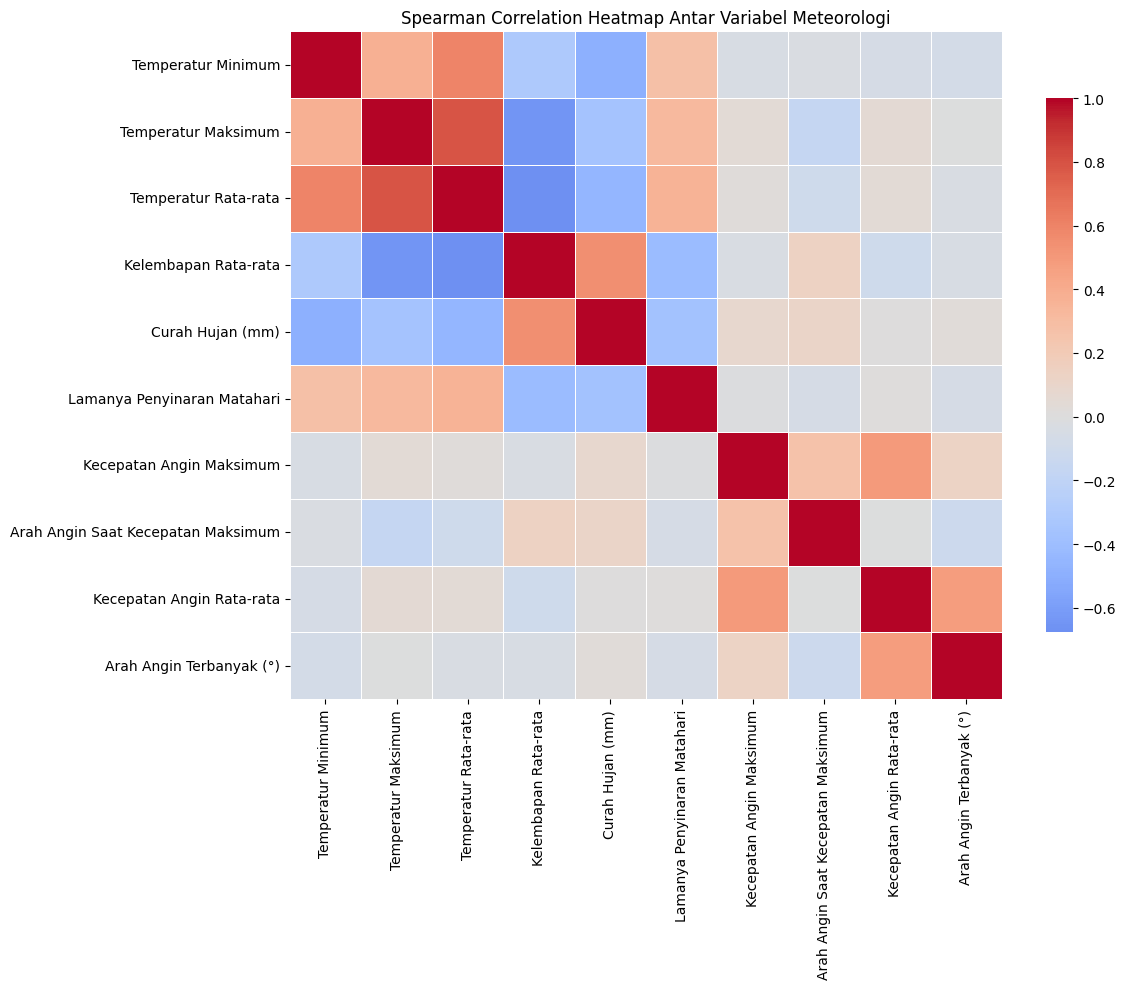

In [100]:
df_corr = data1.select_dtypes(include=[np.number])

# Spearman correlation (lebih robust utk non-linear)
corr = df_corr.corr(method="spearman")

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Spearman Correlation Heatmap Antar Variabel Meteorologi")
plt.tight_layout()
plt.show()


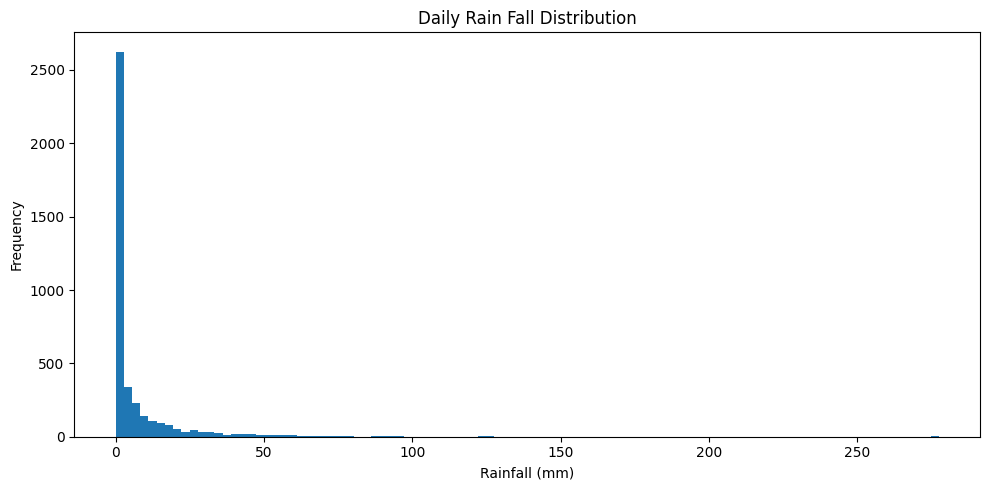

Persentase hari tanpa hujan: 45.02%


In [101]:
plt.figure(figsize=(10, 5))
plt.hist(data1["Curah Hujan (mm)"], bins=100)
plt.xlabel("Rainfall (mm)")
plt.ylabel("Frequency")
plt.title("Daily Rain Fall Distribution")
plt.tight_layout()
plt.show()


zero_ratio = (data1["Curah Hujan (mm)"] == 0).mean() * 100
print(f"Persentase hari tanpa hujan: {zero_ratio:.2f}%")


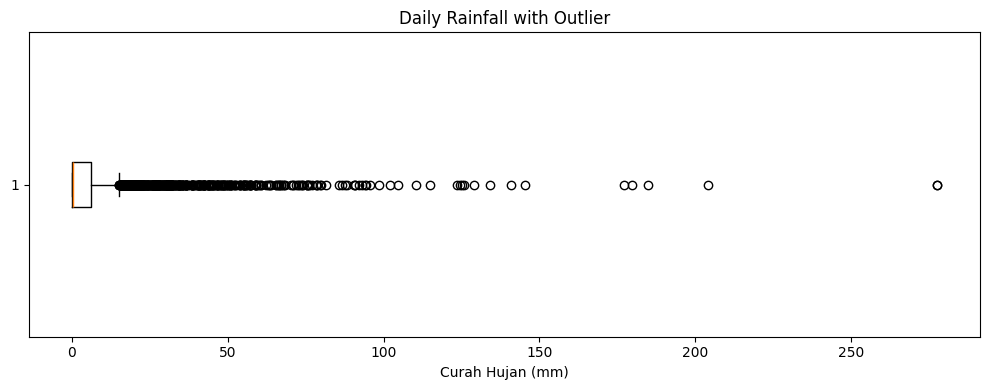

In [102]:
import matplotlib.pyplot as plt

# Ambil hanya kolom numerik RR
rr = data1["Curah Hujan (mm)"].dropna()

plt.figure(figsize=(10, 4))
plt.boxplot(rr, vert=False)
plt.xlabel("Curah Hujan (mm)")
plt.title("Daily Rainfall with Outlier")
plt.tight_layout()
plt.show()

# Persistence Model

In [103]:
df = data1.sort_values("Tanggal").reset_index(drop=True)

# Target = curah hujan besok
df["RR_t+1"] = df["Curah Hujan (mm)"].shift(-1)

df["RR_pred_persistence"] = df["Curah Hujan (mm)"]

# Buang NaN akibat shift
eval_df = df.dropna(subset=["RR_t+1", "RR_pred_persistence"])

y_true = eval_df["RR_t+1"]
y_pred = eval_df["RR_pred_persistence"]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"\nPERSISTENCE BASELINE RESULTS:")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")


PERSISTENCE BASELINE RESULTS:
MAE  : 9.285
RMSE : 21.275


# Classification Baseline Model

In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error,f1_score, classification_report


df = data1.copy()

# Target: kejadian hujan besok
df["Rain_Event_t+1"] = (df["Curah Hujan (mm)"].shift(-1) > 0).astype(int)

# Drop baris terakhir akibat shift
df = df.dropna(subset=["Rain_Event_t+1"])

# Baseline features (RAW, tanpa feature engineering)
baseline_features = [
    "Temperatur Rata-rata",
    "Temperatur Maksimum",
    "Temperatur Minimum",
    "Kelembapan Rata-rata",
    "Lamanya Penyinaran Matahari",
    "Kecepatan Angin Rata-rata",
    "Kecepatan Angin Maksimum",
    "Arah Angin Terbanyak (°)"
]

X = df[baseline_features]
y = df["Rain_Event_t+1"]

# Time-based train-test split (80:20)
split_idx = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Baseline Random Forest Classifier
rf_baseline = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf_baseline.fit(X_train, y_train)

# Prediction
y_pred = rf_baseline.predict(X_test)
y_proba = rf_baseline.predict_proba(X_test)[:, 1]

# Evaluation
print("=== BASELINE CLASSIFICATION RESULTS ===")
print(classification_report(
    y_test,
    y_pred,
    target_names=["Tidak Hujan", "Hujan"]
))


=== BASELINE CLASSIFICATION RESULTS ===
              precision    recall  f1-score   support

 Tidak Hujan       0.66      0.56      0.61       373
       Hujan       0.66      0.75      0.71       431

    accuracy                           0.66       804
   macro avg       0.66      0.66      0.66       804
weighted avg       0.66      0.66      0.66       804



# Regression Baseline Model

In [105]:
baseline_features = [
    "Temperatur Rata-rata",
    "Temperatur Maksimum",
    "Temperatur Minimum",
    "Kelembapan Rata-rata",
    "Lamanya Penyinaran Matahari",
    "Kecepatan Angin Rata-rata",
    "Kecepatan Angin Maksimum",
    "Arah Angin Terbanyak (°)"
]

data1["Rain_mm_t+1"] = data1["Curah Hujan (mm)"].shift(-1)
df_baseline_rain = data1[data1["Rain_mm_t+1"] > 0].copy()

X_base_reg = df_baseline_rain[baseline_features]
y_base_reg = np.log1p(df_baseline_rain["Rain_mm_t+1"])


split_ratio = 0.8

split_idx_reg = int(len(X_base_reg) * split_ratio)
X_base_reg_train = X_base_reg.iloc[:split_idx_reg]
X_base_reg_test = X_base_reg.iloc[split_idx_reg:]
y_base_reg_train = y_base_reg.iloc[:split_idx_reg]
y_base_reg_test = y_base_reg.iloc[split_idx_reg:]

reg_baseline = XGBRegressor(
    n_estimators=800,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

reg_baseline.fit(X_base_reg_train, y_base_reg_train)

y_base_reg_pred_log = reg_baseline.predict(X_base_reg_test)
y_base_reg_pred = np.expm1(y_base_reg_pred_log)
y_base_reg_true = np.expm1(y_base_reg_test)

# Metrics
baseline_mae = mean_absolute_error(y_base_reg_true, y_base_reg_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_base_reg_true, y_base_reg_pred))

print(f"\nBASELINE REGRESSION RESULTS:")
print(f"MAE:  {baseline_mae:.3f} mm")
print(f"RMSE: {baseline_rmse:.3f} mm")


BASELINE REGRESSION RESULTS:
MAE:  10.681 mm
RMSE: 20.818 mm


# Feature Engineering

In [106]:
#Check Correlation

df3 = pd.read_excel("Ready_To_Use.xlsx")

numeric_df = df3.select_dtypes(include=[np.number])

target_corr = numeric_df.corr()['Curah Hujan (mm)'].abs().sort_values(ascending=False)

print(target_corr)


Curah Hujan (mm)                      1.000000
Temperatur Minimum                    0.398884
Kelembapan Rata-rata                  0.396435
Temperatur Rata-rata                  0.388476
Temperatur Maksimum                   0.320579
Lamanya Penyinaran Matahari           0.191704
Arah Angin Saat Kecepatan Maksimum    0.083891
Kecepatan Angin Rata-rata             0.026568
Arah Angin Terbanyak (°)              0.013974
Kecepatan Angin Maksimum              0.006443
Unnamed: 0                            0.003178
Name: Curah Hujan (mm), dtype: float64


In [107]:
# Sort Date
df3['Tanggal'] = pd.to_datetime(df3['Tanggal'])
df3 = df3.sort_values('Tanggal').reset_index(drop=True)

df3['Curah Hujan Old'] = df3['Curah Hujan (mm)'].copy()

lags = [1, 2, 3, 4]

Features = [
    "Curah Hujan (mm)",
    "Kelembapan Rata-rata",
    "Temperatur Rata-rata",
    "Temperatur Maksimum",
    "Temperatur Minimum",
    "Lamanya Penyinaran Matahari"
]

# Buat lag features dulu
for col in Features:
    for lag in lags:
        df3[f"{col}_lag_{lag}"] = df3[col].shift(lag)

#Buat rolling mean untuk features
windows = [3, 7]


roll_features = {
    "Curah Hujan (mm)": "Rain",
    "Kelembapan Rata-rata": "Humidity",
    "Temperatur Rata-rata": "Temp_Avg",
    "Temperatur Maksimum": "Temp_Max",
    "Temperatur Minimum": "Temp_Min",
    "Lamanya Penyinaran Matahari": "Sunshine"
}


for col, prefix in roll_features.items():
    for w in windows:
        df3[f"{prefix}_roll_{w}"] = (
            df3[col]
            .shift(1)
            .rolling(window=w)
            .mean()
        )

# Buat EWM untuk curah hujan
df3['Rain_ewm_3'] = df3['Curah Hujan (mm)'].shift(1).ewm(span=3).mean()
df3['Rain_ewm_7'] = df3['Curah Hujan (mm)'].shift(1).ewm(span=7).mean()

# Buat rolling std 
df3['Rain_roll_std_7'] = df3['Curah Hujan (mm)'].shift(1).rolling(7).std()

# Cyclical Encoding 
df3["month"] = df3["Tanggal"].dt.month
df3["dayofyear"] = df3["Tanggal"].dt.dayofyear

df3["sin_doy"] = np.sin(2 * np.pi * df3["dayofyear"] / 365)
df3["cos_doy"] = np.cos(2 * np.pi * df3["dayofyear"] / 365)

q90 = df3["Curah Hujan (mm)"].quantile(0.9)

#Untuk menangkap curah hujan ekstrem
df3["HeavyRain_3d"] = (
    df3["Curah Hujan (mm)"].shift(1).rolling(3).max() > q90
).astype(int)

df3 = df3.iloc[max(lags + windows):].reset_index(drop=True)

df3 = df3.dropna()

df3.to_excel("Data_With_FE.xlsx", index=False)

In [108]:
print(f"Jumlah baris sebelum: {len(df3)}")
df3_clean = df3.dropna().reset_index(drop=True)
print(f"Jumlah baris sesudah: {len(df3_clean)}")
print(f"Baris yang dihapus: {len(df3) - len(df3_clean)}")


Jumlah baris sebelum: 4013
Jumlah baris sesudah: 4013
Baris yang dihapus: 0


In [109]:
df4 = pd.read_excel('Data_With_FE.xlsx', index_col=0)

In [110]:
#Check Correlation After Feature Engineering
numeric_df2 = df4.select_dtypes(include=[np.number])

target_corr = numeric_df2.corr()['Curah Hujan Old'].sort_values(ascending=False)

print(target_corr)

Curah Hujan (mm)                      1.000000
Curah Hujan Old                       1.000000
Kelembapan Rata-rata                  0.395871
Kelembapan Rata-rata_lag_1            0.363848
Humidity_roll_3                       0.298294
Humidity_roll_7                       0.262786
Rain_ewm_7                            0.241087
Rain_ewm_3                            0.224274
Kelembapan Rata-rata_lag_2            0.217166
Rain_roll_7                           0.210414
Rain_roll_3                           0.205835
Kelembapan Rata-rata_lag_3            0.192695
Curah Hujan (mm)_lag_1                0.183399
cos_doy                               0.179374
Kelembapan Rata-rata_lag_4            0.178831
Rain_roll_std_7                       0.168731
sin_doy                               0.140797
HeavyRain_3d                          0.140652
Curah Hujan (mm)_lag_2                0.134496
Curah Hujan (mm)_lag_3                0.093959
Curah Hujan (mm)_lag_4                0.085130
Arah Angin Sa

In [111]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4013 entries, 371 to 4019
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Tanggal                             4013 non-null   datetime64[ns]
 1   Temperatur Minimum                  4013 non-null   float64       
 2   Temperatur Maksimum                 4013 non-null   float64       
 3   Temperatur Rata-rata                4013 non-null   float64       
 4   Kelembapan Rata-rata                4013 non-null   int64         
 5   Curah Hujan (mm)                    4013 non-null   float64       
 6   Lamanya Penyinaran Matahari         4013 non-null   float64       
 7   Kecepatan Angin Maksimum            4013 non-null   int64         
 8   Arah Angin Saat Kecepatan Maksimum  4013 non-null   int64         
 9   Kecepatan Angin Rata-rata           4013 non-null   int64         
 10  Arah Angin Terbanyak (°)   

# Data Split

In [112]:
df4 = df4.sort_values("Tanggal").reset_index(drop=True)


df4["Rain_Event_today"] = (df4["Curah Hujan Old"] > 0).astype(int)
TARGET = "Rain_Event_today"

Column_to_drop = [
 "Tanggal",
 "Temperatur Minimum",  
 "Temperatur Maksimum",     
 "Temperatur Rata-rata",     
 "Kelembapan Rata-rata",
 "Curah Hujan Old",
 "Curah Hujan (mm)",
 "Lamanya Penyinaran Matahari",
 "Kecepatan Angin Maksimum",        
 "Arah Angin Saat Kecepatan Maksimum", 
 "Kecepatan Angin Rata-rata",     
 "Arah Angin Terbanyak (°)", 
 "Rain_Event_today"
]

X = df4.drop(columns=Column_to_drop, errors="ignore")
y = df4[TARGET]

In [113]:
split_ratio = 0.8
split_idx = int(len(X) * split_ratio)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


In [114]:
# Cek distribusi
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Rain_Event_today
1    0.552648
0    0.447352
Name: proportion, dtype: float64
Rain_Event_today
1    0.536737
0    0.463263
Name: proportion, dtype: float64


# Data Modelling 

## Classification

In [115]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=6,
    min_samples_leaf=10,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)


clf.fit(X_train, y_train)

proba = clf.predict_proba(X_test)

if proba.shape[1] == 2:
    y_pred_prob = proba[:, 1]
else:
    y_pred_prob = np.zeros(len(X_test))

rain_threshold = 0.5
y_pred_cls = (y_pred_prob >= rain_threshold).astype(int)

print(
    "Stage 1 — Rain Event Accuracy:",
    accuracy_score(y_test, y_pred_cls)
)


Stage 1 — Rain Event Accuracy: 0.709838107098381


In [116]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred_cls))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69       372
           1       0.73      0.72      0.73       431

    accuracy                           0.71       803
   macro avg       0.71      0.71      0.71       803
weighted avg       0.71      0.71      0.71       803

ROC-AUC: 0.7741062295736347



Top 10 Most Important Features:
                       feature  importance
4   Kelembapan Rata-rata_lag_1    0.172347
37                  Rain_ewm_7    0.082819
26             Humidity_roll_3    0.080511
8   Temperatur Rata-rata_lag_1    0.060849
36                  Rain_ewm_3    0.055350
25                 Rain_roll_7    0.054140
38             Rain_roll_std_7    0.051775
27             Humidity_roll_7    0.040613
24                 Rain_roll_3    0.036300
3       Curah Hujan (mm)_lag_4    0.034982


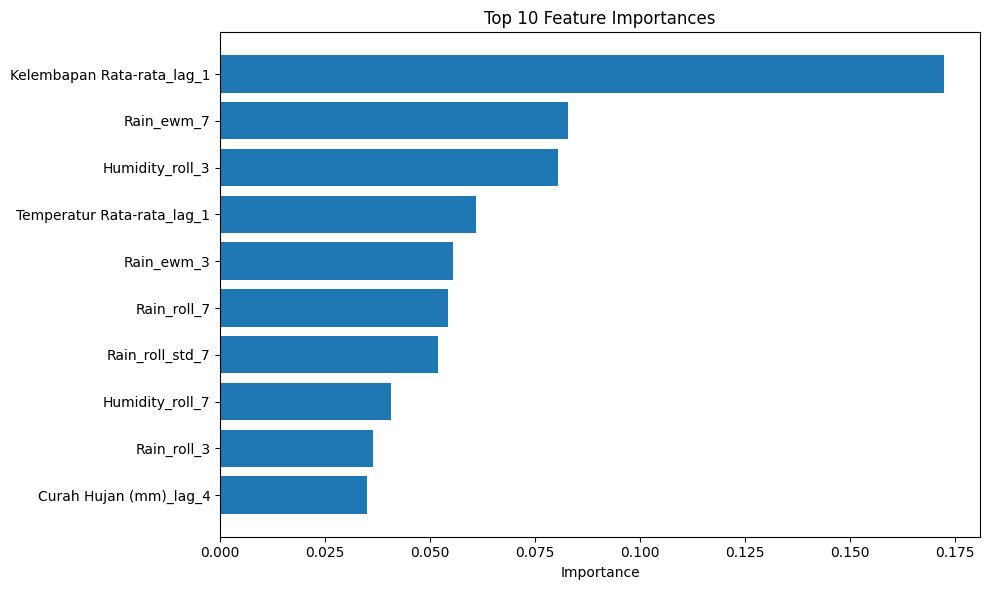

In [119]:
import matplotlib.pyplot as plt

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance.head(10)['feature'], 
         feature_importance.head(10)['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

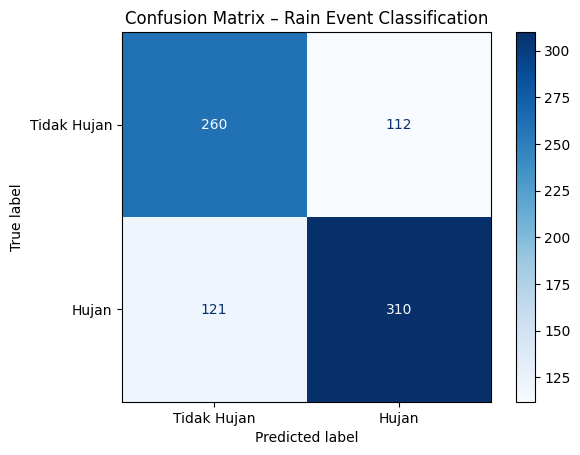

In [120]:
#Confusion Matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_cls)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Tidak Hujan", "Hujan"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Rain Event Classification")
plt.show()


## Regression

In [122]:
from xgboost import XGBRegressor

df4["Rain_mm_t+1"] = df4["Curah Hujan Old"].shift(-1)

df4["Rain_Event_true"] = (df4["Rain_mm_t+1"] > 0).astype(int)
df4_rain = df4[df4["Rain_Event_true"] == 1].copy()


feature_cols = X_train.columns.tolist()  # X_train dari klasifikasi

X_rain = df4_rain[feature_cols]
y_rain = np.log1p(df4_rain["Rain_mm_t+1"])

In [123]:
split_ratio2 = 0.8
split_idx_rain2 = int(len(X_rain) * split_ratio)

X_rain_train, X_rain_test = X_rain.iloc[:split_idx_rain2], X_rain.iloc[split_idx_rain2:]
y_rain_train, y_rain_test = y_rain.iloc[:split_idx_rain2], y_rain.iloc[split_idx_rain2:]

In [124]:
reg = XGBRegressor(
    n_estimators=800,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    reg_alpha=0.5,
    reg_lambda=1.5,
    objective="reg:squarederror",
    random_state=42
)

reg.fit(X_rain_train, y_rain_train)

X_test_reg = df4.loc[X_test.index, feature_cols] 

final_pred = []

for i, idx in enumerate(X_test.index):
    prob = y_pred_prob[i]  # probabilitas hujan dari model klasifikasi

    if prob < rain_threshold:
        final_pred.append(0.0)
    else:
        rain_log = reg.predict(X_test_reg.loc[[idx]])[0]
        rain_mm  = np.expm1(rain_log)
        final_pred.append(prob * rain_mm)

final_pred = np.array(final_pred)

In [125]:
y_true = df4.loc[X_test.index, "Rain_mm_t+1"]
mask = ~y_true.isna()

mae  = mean_absolute_error(y_true[mask], final_pred[mask])
rmse = np.sqrt(mean_squared_error(y_true[mask], final_pred[mask]))
mse  = mean_squared_error(y_true[mask], final_pred[mask])

print(f"MAE  : {mae:.3f} mm")
print(f"MSE  : {mse:.3f} mm²")
print(f"RMSE : {rmse:.3f} mm")

MAE  : 6.764 mm
MSE  : 270.657 mm²
RMSE : 16.452 mm


In [126]:
hasil_prediksi = pd.DataFrame({
    "Tanggal": df4.loc[X_test.index, "Tanggal"],
    "Prob_Rain": y_pred_prob,
    "Pred_Rain_mm": final_pred,
    "Actual_Rain_mm": y_true.values
})

hasil_prediksi.to_excel(
    "hasil_prediksi_regresi.xlsx",
    index=False
)



# Visualization